In [1]:
# If you're using Jupyter locally and haven't installed it yet:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 3.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.0/991.0 kB 4.9 MB/s eta 0:00:00


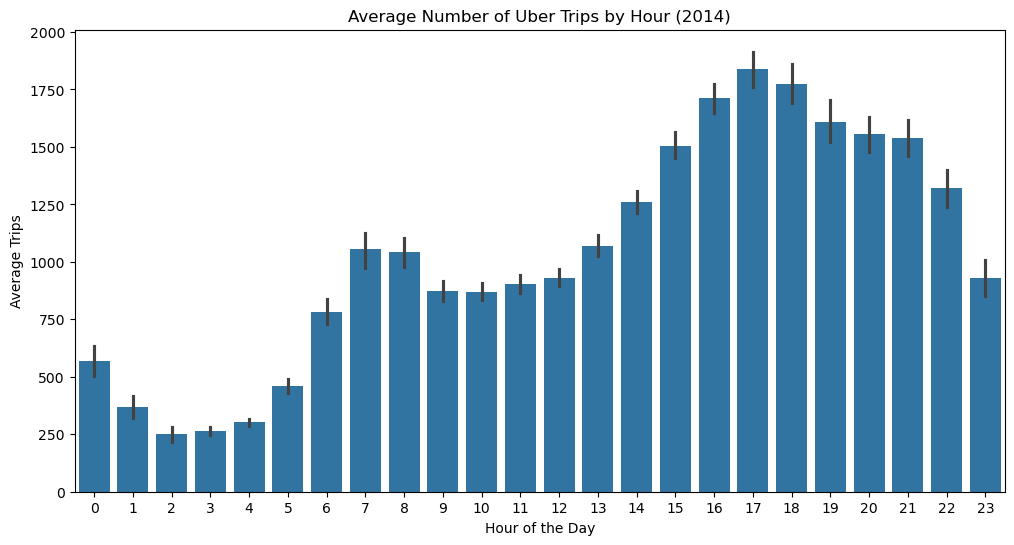

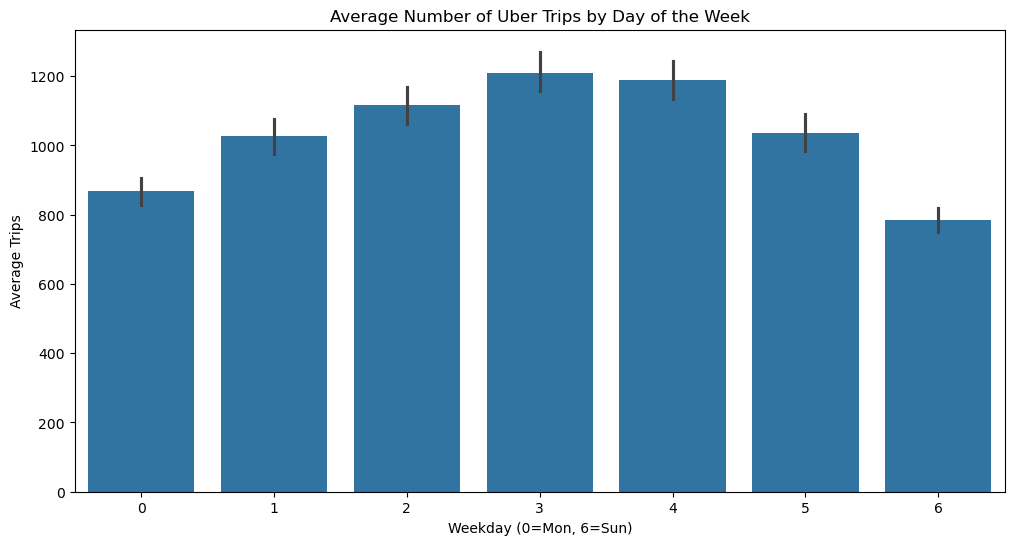

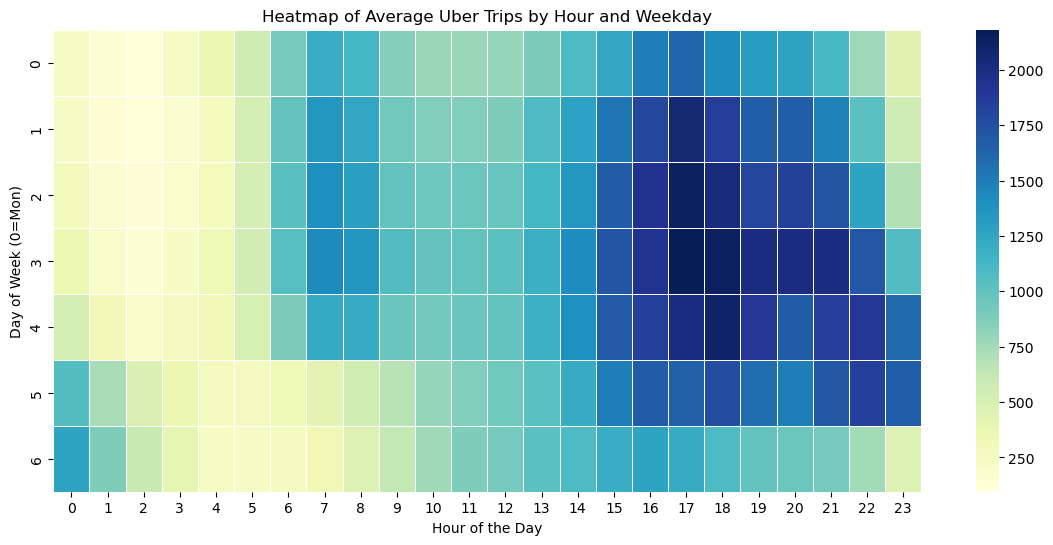

In [4]:
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns

hourly_trips = pd.read_csv("uber_hourly_trip_data.csv", parse_dates=['Datetime_Hour'])

# Extract additional time info
hourly_trips['Hour'] = hourly_trips['Datetime_Hour'].dt.hour
hourly_trips['Weekday'] = hourly_trips['Datetime_Hour'].dt.dayofweek
hourly_trips['Date'] = hourly_trips['Datetime_Hour'].dt.date

#1. Plot trips per hour (overall)
plt.figure(figsize=(12,6))
sns.barplot(x='Hour', y='Trip_Count', data=hourly_trips)
plt.title('Average Number of Uber Trips by Hour (2014)')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Trips')
plt.show()

#2. Plot trips per weekday
plt.figure(figsize=(12,6))
sns.barplot(x='Weekday', y='Trip_Count', data=hourly_trips)
plt.title('Average Number of Uber Trips by Day of the Week')
plt.xlabel('Weekday (0=Mon, 6=Sun)')
plt.ylabel('Average Trips')
plt.show()

#3. Heatmap: Hour vs Weekday
pivot_table = hourly_trips.pivot_table(index='Weekday', columns='Hour', values='Trip_Count', aggfunc='mean')

plt.figure(figsize=(14,6))
sns.heatmap(pivot_table, cmap="YlGnBu", linewidths=0.5)
plt.title('Heatmap of Average Uber Trips by Hour and Weekday')
plt.xlabel('Hour of the Day')
plt.ylabel('Day of Week (0=Mon)')
plt.show()


In [5]:
from prophet import Prophet

# Use your hourly trip data
df_prophet = hourly_trips.copy()
df_prophet = df_prophet.rename(columns={"Datetime_Hour": "ds", "Trip_Count": "y"})


In [6]:
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,  # We don’t have a full year of data
    changepoint_range=0.9
)
model.fit(df_prophet)


13:55:23 - cmdstanpy - INFO - Chain [1] start processing
13:55:24 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# Create a dataframe for future 100 hours
future = model.make_future_dataframe(periods=100, freq='h')  # H = Hourly
forecast = model.predict(future)


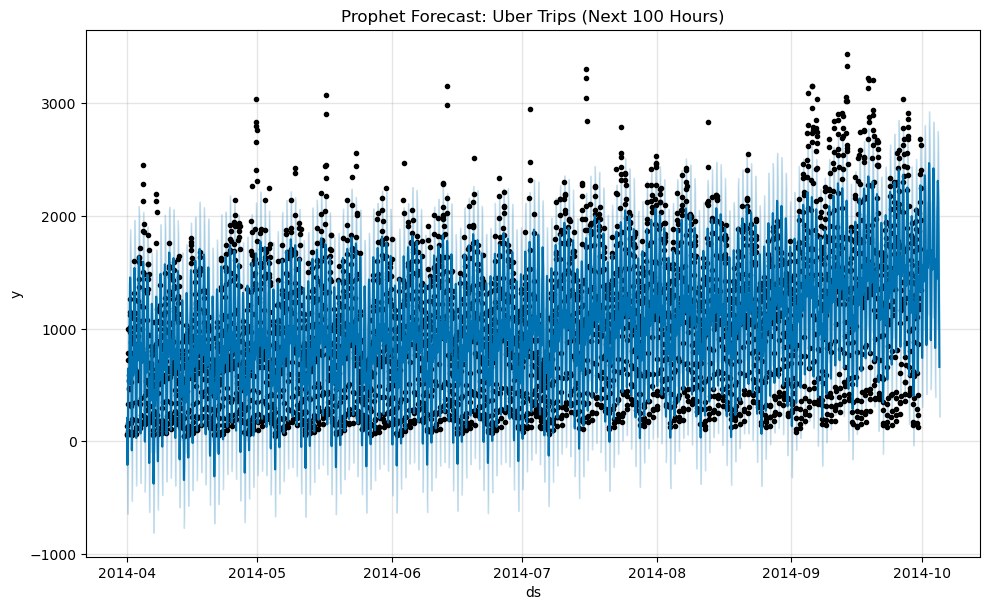

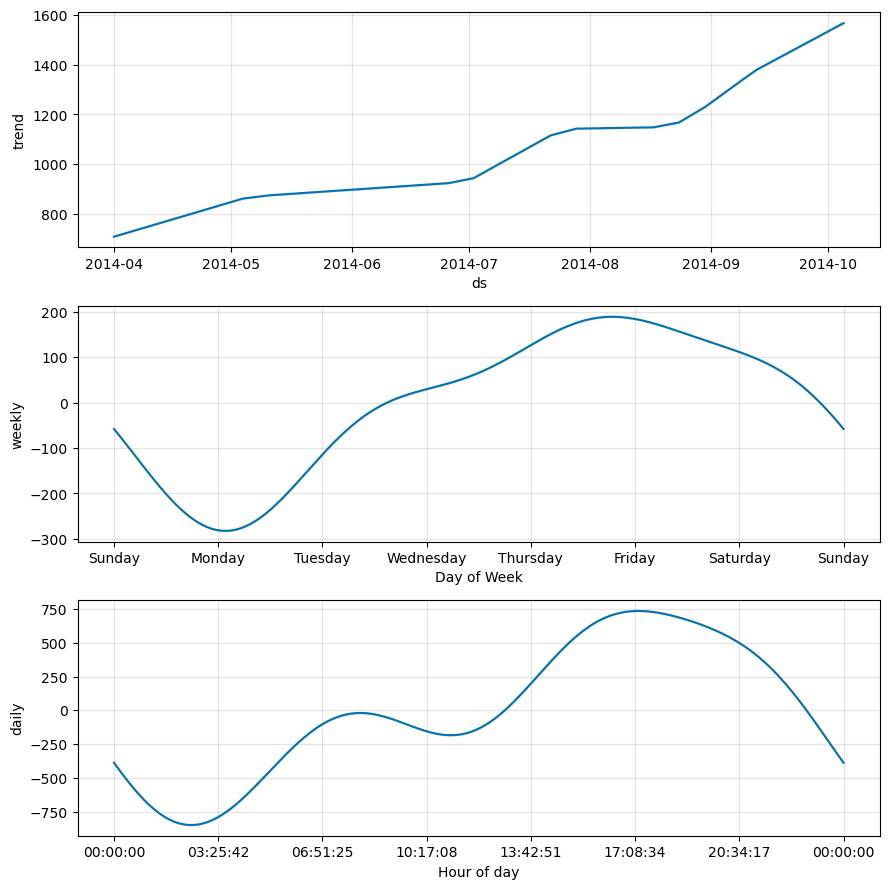

In [9]:
# Plot forecast
fig1 = model.plot(forecast)
plt.title("Prophet Forecast: Uber Trips (Next 100 Hours)")
plt.show()

# Plot components: trend, weekly, daily seasonality
fig2 = model.plot_components(forecast)
plt.show()


In [10]:
# Join forecast with original data to compare last 100 known points
df_merged = df_prophet.set_index('ds').join(forecast.set_index('ds')[['yhat']], how='inner')

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = df_merged['y'][-100:]
y_pred = df_merged['yhat'][-100:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"Prophet MAE: {mae:.2f}")
print(f"Prophet RMSE: {rmse:.2f}")
print(f"Prophet MAPE: {mape:.2f}%")


Prophet MAE: 349.24
Prophet RMSE: 443.37
Prophet MAPE: 45.43%
